In [20]:
import pandas as pd
import numpy as np
import math
import yfinance as yf
import matplotlib.pyplot as plt

In [21]:
stock_symbol = 'AAPL'
stock_data = (yf.download(stock_symbol, start="2010-01-01", end=pd.Timestamp.now())).resample('3M').mean()['Open']

[*********************100%%**********************]  1 of 1 completed


### Check stationarity of dataset using Augmented Dickey-Fuller test. If data is non-stationary, identify the value of 'd' which converts data to stationary data

In [22]:
from statsmodels.tsa.stattools import adfuller

# Function to perform Augmented Dickey-Fuller test
def adf_test(timeseries):
    result = adfuller(timeseries, autolag='AIC')
    print('ADF Statistic: {:.3f}'.format(result[0]))
    print('p-value: {:.3f}'.format(result[1]))
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {:.3f}'.format(key, value))

# Perform Augmented Dickey-Fuller test
adf_test(stock_data)


ADF Statistic: 0.680
p-value: 0.989
Critical Values:
	1%: -3.581
	5%: -2.927
	10%: -2.602


In [23]:
# Take first difference to make data stationary
stock_prices_diff = stock_data.diff().dropna()

# Perform Augmented Dickey-Fuller test on differenced data
adf_test(stock_prices_diff)


ADF Statistic: -0.832
p-value: 0.809
Critical Values:
	1%: -3.581
	5%: -2.927
	10%: -2.602


In [24]:
# Take second difference to make data stationary
stock_prices_diff2 = stock_prices_diff.diff().dropna()

# Perform Augmented Dickey-Fuller test on differenced data
adf_test(stock_prices_diff2)

ADF Statistic: -4.999
p-value: 0.000
Critical Values:
	1%: -3.581
	5%: -2.927
	10%: -2.602


#### d = 2

### Identify coefficients 'p' and 'q' using Auto-correlation Function (ACF) & Partial auto-correlation function (PACF) plots

(<Figure size 640x480 with 1 Axes>, <Figure size 640x480 with 1 Axes>)

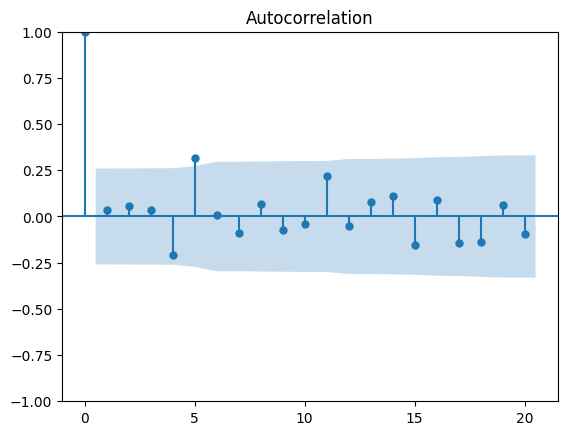

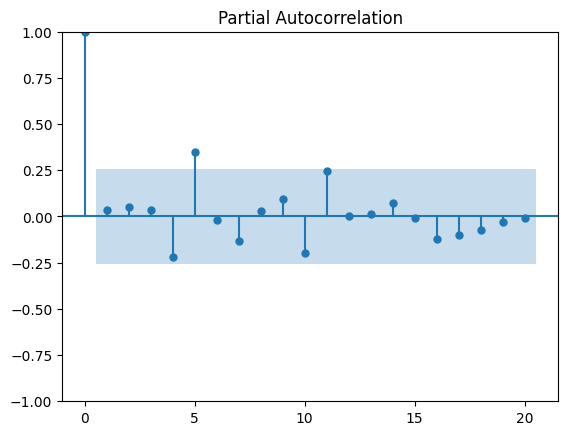

In [25]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot ACF
plot_acf(stock_prices_diff, lags=20),plot_pacf(stock_prices_diff, lags=20)


#### p = 5, q = 5

### Fit an ARIMA model on 80% of the historic data (train) using the p,q and d parameters and use the recent 20% data as 'test'

In [26]:
from statsmodels.tsa.arima.model import ARIMA

# Split data into train and test sets
train_size = int(len(stock_data) * 0.8)
train, test = stock_data[:train_size], stock_data[train_size:]

# Fit ARIMA model
model = ARIMA(train, order=(2,1,5)) # Example order, replace with identified values
model_fit = model.fit()
print(model_fit.summary())


                               SARIMAX Results                                
Dep. Variable:                   Open   No. Observations:                   46
Model:                 ARIMA(2, 1, 5)   Log Likelihood                -139.567
Date:                Wed, 01 May 2024   AIC                            295.134
Time:                        17:09:21   BIC                            309.588
Sample:                    01-31-2010   HQIC                           300.522
                         - 04-30-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3481      1.857     -0.187      0.851      -3.988       3.292
ar.L2          0.5136      0.880      0.583      0.560      -1.212       2.239
ma.L1          0.6787      1.988      0.341      0.7

d:\miniconda\envs\ml\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [27]:
# Get predictions
train_predictions = model_fit.predict(start=train.index[1], end=train.index[-1], typ='levels')
test_predictions = model_fit.forecast(steps=len(test))

# Calculate errors
train_errors = train - train_predictions
test_errors = test - test_predictions

### Evaluate the fitted model on various statistical metrics for error on 'train' and 'test'

In [28]:

# Evaluate on statistical metrics
train_rmse = np.sqrt(np.mean(train_errors**2))
test_rmse = np.sqrt(np.mean(test_errors**2))
print('Train RMSE:', train_rmse)
print('Test RMSE:', test_rmse)


Train RMSE: 5.280593529188685
Test RMSE: 20.319001759708826


### Assess the model on metrics that calculate goodness of fit on 'train' and 'test'

In [29]:

# Assess goodness of fit
train_r_squared = 1 - (np.var(train_errors) / np.var(train))
test_r_squared = 1 - (np.var(test_errors) / np.var(test))
print('Train R-squared:', train_r_squared)
print('Test R-squared:', test_r_squared)


Train R-squared: 0.9680901085383098
Test R-squared: 0.11335504442920685


### Compare the performance of this model with your previously trained OLS model in Experiment 8

In [30]:
from sklearn.linear_model import LinearRegression

# Generate features for OLS (e.g., lagged values)
lag = 7  # Example lag value
stock_prices_df = pd.DataFrame(stock_data.copy(), columns=['Open'])
for i in range(1, lag+1):
    stock_prices_df[f'Lag_{i}'] = stock_prices_df['Open'].shift(i)

# Split data into train and test sets
train_size = int(len(stock_prices_df) * 0.8)
train_df, test_df = stock_prices_df.iloc[:train_size], stock_prices_df.iloc[train_size:]

# Drop missing values
train_df.dropna(inplace=True)
test_df.dropna(inplace=True)

# Define features and target for OLS
X_train = train_df.drop(columns=['Open'])
y_train = train_df['Open']
X_test = test_df.drop(columns=['Open'])

# Fit OLS model
ols_model = LinearRegression()
ols_model.fit(X_train, y_train)

# Predictions
ols_train_predictions = ols_model.predict(X_train)
ols_test_predictions = ols_model.predict(X_test)


C:\Users\Rommel\AppData\Local\Temp\ipykernel_3164\3881029491.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.dropna(inplace=True)
C:\Users\Rommel\AppData\Local\Temp\ipykernel_3164\3881029491.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df.dropna(inplace=True)


### Compute Theil's coefficient of the 2 forecasts (OLS, ARIMA) for any one stock forecast  

In [31]:
# Assuming you have another forecast (OLS) available
# Calculate Theil's coefficient
def theil_coefficient(ols_forecast, arima_forecast, actual):
    numerator = np.sqrt(np.mean((arima_forecast - actual)**2))
    denominator = np.sqrt(np.mean((ols_forecast - actual)**2))
    return numerator / denominator

# Compute Theil's coefficient
theil_coeff = theil_coefficient(ols_test_predictions, test_predictions, test)
print('Theil\'s coefficient:', theil_coeff)


Theil's coefficient: 0.839278680832617
